In [1]:
#Import libraries
import logging
import sys
import os
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import tqdm
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow.keras as keras
from tensorflow.python.keras import backend as K
import pickle
import math
import time
import shutil
import glob
import random as rd
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
onionAddressData = {}
intervalBetweenOnionAcessTimestamps = 1

FORCED_TIMESTAMPS = True
FORCED_TIMESTAMPS_INTERVAL = (-1,1)

unCorrelatedClassLimit = 0
classes = {}
classes['sameOnionSameClient'] = 2
classes['sameOnionDiffClient'] = 2
classes['diffOnionSameClient'] = 0
classes['diffOnionDiffClient'] = 0

negetive_samples_training = 0
negetive_samples_test = 0
for key in classes:
    negetive_samples_training += classes[key]
    negetive_samples_test += classes[key]


In [3]:
#Global Variables
BATCH_SIZE = 1024
EPOCH_COUNT = 40
EPOCH_COUNT_SAME_DATASET = 200
learn_rate=0.0001

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)

countMultiplier = 1


In [6]:
baseDatasetPath = '/home/jupyter-atse/datasets/'

metaDataPairsFolders = pickle.load(open(baseDatasetPath + 'metaDataPairsFolders', 'rb'))
trainPairsFolders = pickle.load(open(baseDatasetPath + 'trainPairsFolders', 'rb'))
testPairsFolders = pickle.load(open(baseDatasetPath + 'testPairsFolders', 'rb'))


In [7]:
def generateDataset(pairsFoldersInput, negetive_samples):

    index = 0

    l2s=np.zeros((len(pairsFoldersInput)*(negetive_samples+1),3))
    labels=np.zeros((len(pairsFoldersInput)*(negetive_samples+1),1))
    for pairFolder in pairsFoldersInput:

        clientInitialTimeStamp = pairFolder['clientMetaStats']['initialTimestamp']
        clientIn = pairFolder['clientMetaStats']['sizesIn']
        clientOut = pairFolder['clientMetaStats']['sizesOut']

        hsInitialTimeStamp = pairFolder['hsMetaStats']['initialTimestamp']
        hsIn = pairFolder['hsMetaStats']['sizesIn']
        hsOut = pairFolder['hsMetaStats']['sizesOut']

        timeDifference = hsInitialTimeStamp-clientInitialTimeStamp
        originalTimeDifference = timeDifference

        l2s[index,2]=timeDifference
        l2s[index,0]=hsIn - clientOut
        l2s[index,1]=hsOut - clientIn

        labels[index, 0] = 1

        index += 1

        classesTmp = {}
        for key in classes:
            classesTmp[key] = classes[key]
        random = list(range(len(pairsFoldersInput)))
        np.random.shuffle(random)
        negetive_samples_current = 0
        for negetive_pair_index in random:

            #skip if is the original correlated pair
            if pairsFoldersInput[negetive_pair_index]['hsFolder'] == pairFolder['hsFolder']:
                continue

            
            #same onion
            if pairsFoldersInput[negetive_pair_index]['onionAddress'] == pairFolder['onionAddress']:
                #same client
                if pairsFoldersInput[negetive_pair_index]['clientLocation'] == pairFolder['clientLocation']:
                    if classesTmp['sameOnionSameClient'] == 0:
                        continue
                    classesTmp['sameOnionSameClient'] -= 1
                #different client 
                else:
                    if classesTmp['sameOnionDiffClient'] == 0:
                        continue
                    classesTmp['sameOnionDiffClient'] -= 1
            #different onion
            else:
                #same client
                if pairsFoldersInput[negetive_pair_index]['clientLocation'] == pairFolder['clientLocation']:
                    if classesTmp['diffOnionSameClient'] == 0:
                        continue
                    classesTmp['diffOnionSameClient'] -= 1
                #different client
                else:
                    if classesTmp['diffOnionDiffClient'] == 0:
                        continue
                    classesTmp['diffOnionDiffClient'] -= 1


            hsInitialTimeStamp = pairsFoldersInput[negetive_pair_index]['hsMetaStats']['initialTimestamp']
            hsIn = pairsFoldersInput[negetive_pair_index]['hsMetaStats']['sizesIn']
            hsOut = pairsFoldersInput[negetive_pair_index]['hsMetaStats']['sizesOut']

            timeDifference = hsInitialTimeStamp-pairsFoldersInput[negetive_pair_index]['clientMetaStats']['initialTimestamp']
            if FORCED_TIMESTAMPS:
                timeDifference = originalTimeDifference+rd.uniform(FORCED_TIMESTAMPS_INTERVAL[0], FORCED_TIMESTAMPS_INTERVAL[1])


            l2s[index,2]=timeDifference
            l2s[index,0]=hsIn - clientOut
            l2s[index,1]=hsOut - clientIn

            labels[index, 0] = 0

            index += 1

            negetive_samples_current += 1
            if negetive_samples_current >= negetive_samples:
                break

    return l2s, labels

In [ ]:
models = [0] * 10

cnnLayers = [10]
nnLayers = [150,140,130,120,110,100,90,80,70,60]
precision_value = []
execution_time = []
dropout_prob = 0.4

for i in range(10):
    print(nnLayers[i])
    models[i] = tf.keras.Sequential()
  
    models[i].add(tf.keras.layers.Dense(300, input_shape=[3], kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    models[i].add(tf.keras.layers.Activation('relu'))
    models[i].add(tf.keras.layers.Dropout(dropout_prob))

    models[i].add(tf.keras.layers.Dense(int(nnLayers[i]), kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)))
    models[i].add(tf.keras.layers.Activation('relu'))
    models[i].add(tf.keras.layers.Dropout(dropout_prob))

    models[i].add(tf.keras.layers.Dense(1))
def customLoss(y_true,y_pred):
    #return tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred,labels=y_true),name='loss_sigmoid')

models[i].compile(loss=customLoss, optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate), metrics=['accuracy'])

  # custom function
def sigmoid(x):
    if x < -150:
        x = -150
    if x > 150:
          x = 150
    return 1 / (1 + math.exp(-x))

  # define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

prevAcc = 0

try:
    for epoch in tqdm.tqdm(range(EPOCH_COUNT)):
        l2s, labels = generateDataset(trainPairsFolders, negetive_samples_training)
        rr= list(range(len(l2s)))
        np.random.shuffle(rr)
        l2s=l2s[rr]
        labels=labels[rr]

        history = models[i].fit(l2s, labels, batch_size=BATCH_SIZE, verbose=1, epochs=EPOCH_COUNT_SAME_DATASET)
        loss = history.history['loss'][-1]
        acc = history.history['acc'][-1]
        print("Epoch:", epoch, "loss:", loss, 'acc:', acc)

        if acc >= prevAcc:
            prevAcc = acc
            saveName = 'cnn_firstStage'
            if isdir(saveName):
                shutil.rmtree(saveName)
            models[i].save_weights(saveName + '/cp.ckpt')

except KeyboardInterrupt:
    pass
except:
    raise

    this_execution = np.zeros(10)

    l3s, labels3 = generateDataset(testPairsFolders, negetive_samples_test)
    for j in range(10):
        start_test = time.time()
        test_loss, test_accuracy = models[i].evaluate(l3s,labels3, batch_size=BATCH_SIZE, verbose=1)
        end_test = time.time()
        this_execution[j] = end_test - start_test

    execution_time.append(np.min(this_execution))
    precision_value.append(test_accuracy)

print(execution_time)
print(precision_value)

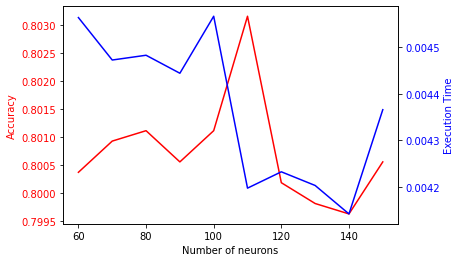

In [17]:
fig, ax1 = plt.subplots() 

ax1.set_xlabel('Number of neurons') 
ax1.set_ylabel('Accuracy', color = 'red') 
ax1.plot(nnLayers, precision_value, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Execution Time', color = 'blue') 
ax2.plot(nnLayers, execution_time, color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue')


plt.show()

In [ ]:
#Model Definition

model = tf.keras.Sequential()


cnnLayers = [10]
nnLayers = [300, 80, 10]
dropout_prob = 0.4
model.add(tf.keras.layers.Dense(int(nnLayers[0]), input_shape=[3], kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(dropout_prob))

model.add(tf.keras.layers.Dense(int(nnLayers[1]), kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(dropout_prob))
model.add(tf.keras.layers.Dense(int(nnLayers[2]), kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(dropout_prob))

model.add(tf.keras.layers.Dense(1))

def customLoss(y_true,y_pred):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred,labels=y_true),name='loss_sigmoid')

model.compile(loss=customLoss, optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate), metrics=['accuracy'])

# custom function
def sigmoid(x):
    if x < -150:
        x = -150
    if x > 150:
        x = 150
    return 1 / (1 + math.exp(-x))

# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

prevAcc = 0

try:
    for epoch in tqdm.tqdm(range(EPOCH_COUNT)):
        l2s, labels = generateDataset(trainPairsFolders, negetive_samples_training)
        rr= list(range(len(l2s)))
        np.random.shuffle(rr)
        l2s=l2s[rr]
        labels=labels[rr]

        history = model.fit(l2s, labels, batch_size=BATCH_SIZE, verbose=1, epochs=EPOCH_COUNT_SAME_DATASET)
        loss = history.history['loss'][-1]
        acc = history.history['acc'][-1]
        print("Epoch:", epoch, "loss:", loss, 'acc:', acc)

        if acc >= prevAcc:
            prevAcc = acc
            saveName = 'cnn_firstStage'
            if isdir(saveName):
                shutil.rmtree(saveName)
            model.save_weights(saveName + '/cp.ckpt')

except KeyboardInterrupt:
    pass
except:
    raise

In [19]:
this_execution = np.zeros(10)

l3s, labels3 = generateDataset(testPairsFolders, negetive_samples_test)
for j in range(10):
    start_test = time.time()
    test_loss, test_accuracy = model.evaluate(l3s,labels3, batch_size=BATCH_SIZE, verbose=1)
    end_test = time.time()
    this_execution[j] = end_test - start_test
print('Accuracy on test dataset:', test_accuracy)
print('Execution time = ', np.min(this_execution))

Accuracy on test dataset: 0.8
Execution time =  0.004952669143676758


In [20]:
print(execution_time)
print(precision_value)

[0.0043659210205078125, 0.004142284393310547, 0.004203319549560547, 0.004232645034790039, 0.004197597503662109, 0.0045664310455322266, 0.004444122314453125, 0.004482746124267578, 0.004472494125366211, 0.004563570022583008]
[0.8005576, 0.79962826, 0.7998141, 0.80018586, 0.80315983, 0.8011152, 0.8005576, 0.8011152, 0.80092937, 0.80037177]
